### Importing libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
import operator
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [4]:
columns = pd.read_csv("columns.csv", header = None).iloc[:,0]
df = pd.read_csv("communities.csv", header = None, names = columns)
non_pred_columns = ["county", "community", "communityname", "fold", "state",]
df = df.drop(non_pred_columns, axis = 1)
df.columns

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=123)

#### Data Imputation Technique: Mean Values substituted for missing values

In [5]:
def imputation_mean(df):
    for column in df.columns:
        df[column] = df[column].replace('?', np.NaN)
        df[column] = df[column].replace(np.NaN, df[column].astype(float).mean(skipna = True))
        df[column] = df[column].astype(float)
    return df

### a) Using "Substitute Mean" as data imputation technique
### b) Splitting the data

In [6]:
df = imputation_mean(df)
labels = df.ViolentCrimesPerPop
df = df.drop(["ViolentCrimesPerPop"], axis = 1)

In [7]:
train_X = df.iloc[0:1495,]
train_Y = labels[0:1495,]
test_X = df.iloc[1495:,]
test_Y = labels[1495:,]

In [8]:
train_X = train_X.reindex(columns=train_X.columns)
test_X = test_X.reindex(columns = test_X.columns)
#train_Y = train_Y.reindex(columns = train_Y.columns)
#test_Y = test_Y.reindex(columns = train_Y.columns)

### c) Correlation matrix

In [9]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
corr = df.corr()
corr

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,0.993112,0.239446,-0.101615,0.004512,-0.130692,-0.150788,-0.120253,0.177172,-0.093911,-0.105370,-0.055656,0.037044,-0.059646,-0.017264,-0.081033,-0.031002,-0.083065,0.947598,0.162004,0.036706,0.057031,-0.003418,0.145247,-0.005217,-0.106284,0.021769,-0.029409,-0.021380,0.232603,0.247567,0.258529,0.248099,0.086666,-0.266341,-0.273558,-0.226710,-0.263348,-0.037165,-0.090191,0.885178,0.332564,0.741593,0.139745,0.156336,0.182920,0.207559,0.199765,0.201221,0.207268,0.211653,-0.168376,0.181610,0.190308,0.123572,-0.036567,-0.003476,0.031548,-0.247854,0.205913,0.218492,-0.205286,0.896324,-0.089887,-0.253136,0.326142,-0.085401,-0.056666,0.061482,0.108046,-0.012131,0.000689,0.018575,-0.006479,-0.009835,0.004060,-0.024675,0.130430,0.083214,-0.037976,0.821243,0.651797,0.172731,-0.125133,-0.123691,0.001610,-0.089638,0.584740,-0.070514,-0.570052,-0.070637,0.594211,0.044787,0.138339,-0.070521,-0.004138,-0.197884,0.185657,0.166094,0.104420,0.248863,0.469583,0.256101,0.116820,0.713652,0.231897,0.270356,0.609147,0.595543,-0.061583,0.076527,0.466352,-0.035576
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,-0.047581,-0.015739,0.209431,0.440269,0.182579,-0.155101,-0.451412,0.115204,-0.324700,0.111438,-0.130716,-0.131671,0.042506,-0.007850,-0.055818,0.016719,-0.085088,-0.030139,0.055085,0.172144,0.100286,-0.033412,0.143811,0.113240,0.023287,-0.084040,0.054622,-0.075045,-0.449461,0.154911,-0.349128,-0.409331,0.845514,0.283067,0.205665,0.199644,0.269767,-0.225673,-0.268500,-0.031316,0.020711,0.105828,0.028751,0.051887,0.069203,0.103577,0.275237,0.288425,0.295677,0.306491,-0.418950,0.416072,0.661575,0.741099,0.892978,0.825000,0.725371,0.138005,0.501638,-0.331717,0.221582,-0.175594,0.230174,0.192774,0.051490,-0.037004,0.253885,-0.007921,0.143368,0.134584,0.123739,0.100420,0.150031,0.167956,0.179718,0.181260,0.130425,0.247992,-0.096443,-0.082164,-0.043011,0.311107,-0.049253,-0.057842,-0.103109,-0.003277,-0.015214,-0.073266,0.017592,-0.086059,-0.003276,-0.054919,0.038658,-0.073238,-0.077769,-0.136626,0.016420,0.151163,0.043773,0.124712,-0.016675,-0.024189,0.034583,-0.015078,-0.004072,-0.051506,-0.032663,-0.007584,-0.006426,-0.000280,-0.0943

### A correlation matrix heatmap to quickly identify the strongest correlations

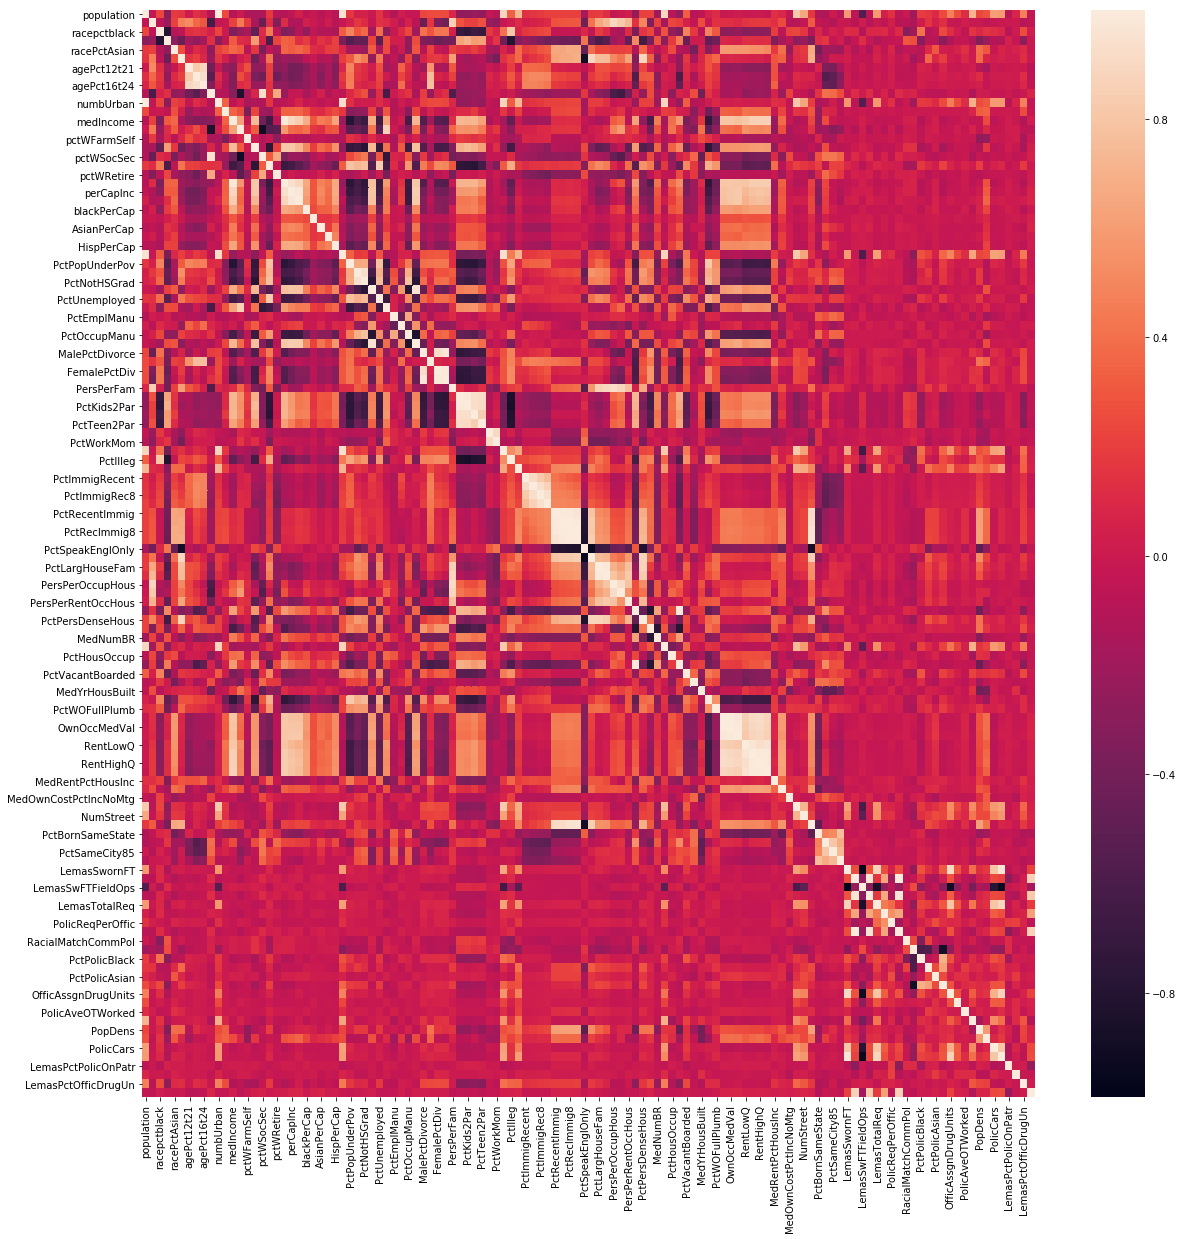

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(corr)

### d) Calculating Coefficient of Variation

In [11]:
coefOfVariation = {}
for column in df.columns:
    coefOfVariation[column] = np.var(df[column])/np.mean(df[column])
coefOfVariation = sorted(coefOfVariation.items(), key = operator.itemgetter(1), reverse = True)
coefOfVariation

[('LemasPctOfficDrugUn', 0.6137947028672666),
 ('NumStreet', 0.442311933599124),
 ('racePctHisp', 0.37511784605156084),
 ('NumInShelters', 0.35745435967186046),
 ('racepctblack', 0.35740724042695965),
 ('NumIlleg', 0.3252191762519837),
 ('PctUsePubTrans', 0.32433293490894527),
 ('PctNotSpeakEnglWell', 0.320419667267697),
 ('PctRecImmig5', 0.3065193968291039),
 ('PctRecentImmig', 0.30639887642132235),
 ('PctRecImmig8', 0.3031656401187059),
 ('PctRecImmig10', 0.30136860810039406),
 ('NumUnderPov', 0.2947518830434201),
 ('HousVacant', 0.29457908261573906),
 ('pctUrban', 0.2840242011580277),
 ('racePctAsian', 0.2837559755365823),
 ('population', 0.27949708582382465),
 ('numbUrban', 0.25660718222293677),
 ('NumImmig', 0.2527659789512013),
 ('PctForeignBorn', 0.24771885991377263),
 ('PctPersDenseHous', 0.23654415671558976),
 ('PctVacantBoarded', 0.2317529531192208),
 ('PctHousNoPhone', 0.22287294986957573),
 ('PctIlleg', 0.21139902495506335),
 ('MedNumBR', 0.20681986197636743),
 ('OwnOccHiQu

### e) 11 features with highest CV and their plots

In [12]:
featuresWithHighestCV = coefOfVariation[0:int(128**0.5)]
featuresWithHighestCV

[('LemasPctOfficDrugUn', 0.6137947028672666),
 ('NumStreet', 0.442311933599124),
 ('racePctHisp', 0.37511784605156084),
 ('NumInShelters', 0.35745435967186046),
 ('racepctblack', 0.35740724042695965),
 ('NumIlleg', 0.3252191762519837),
 ('PctUsePubTrans', 0.32433293490894527),
 ('PctNotSpeakEnglWell', 0.320419667267697),
 ('PctRecImmig5', 0.3065193968291039),
 ('PctRecentImmig', 0.30639887642132235),
 ('PctRecImmig8', 0.3031656401187059)]

In [13]:
features = [f[0] for f in featuresWithHighestCV]

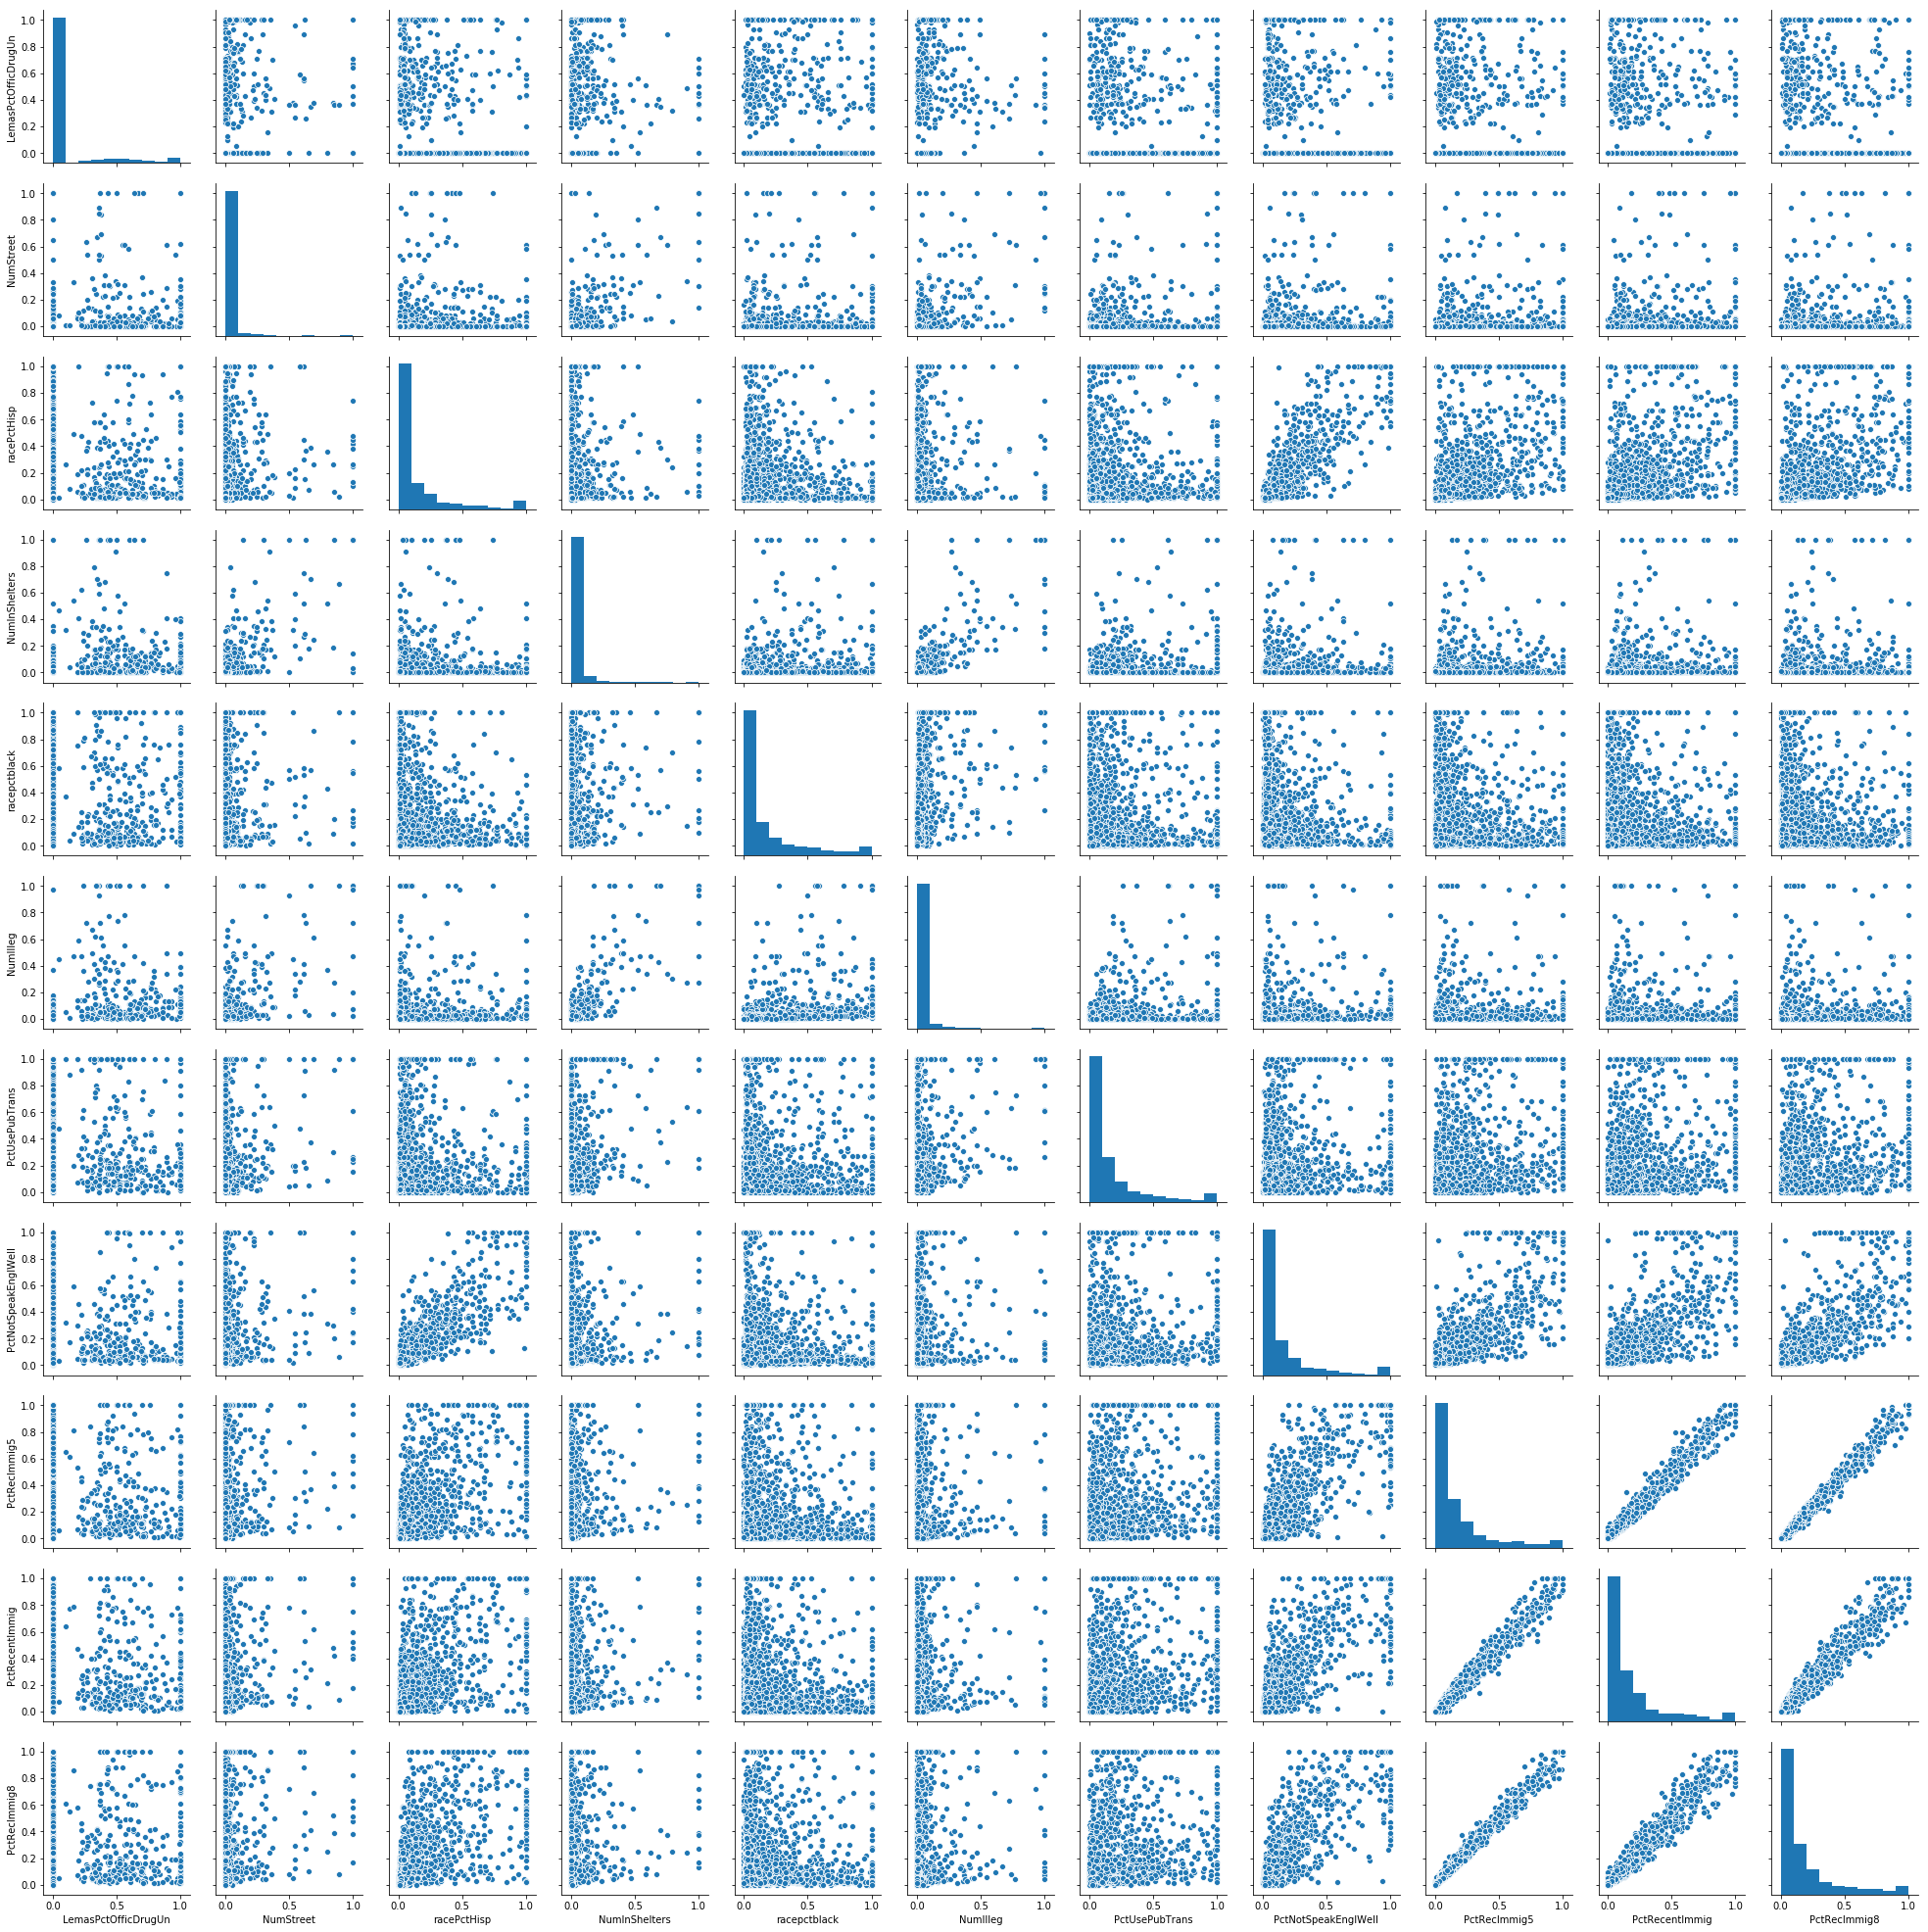

In [14]:
sns.pairplot(data = df[features])

#### It is easily evident from the scatterplots that some features are highly correlated in a linear fashion. Some examples are :
- PctRecentImmig vs PctRecImmig5
- PctRecImmig8 vs PctRecImmig5
- PctRecentImmig vs PctRecImmig8
- We know that features that are highly correlated often tend to hide how they react individually with the reponse. This might have to be taken care of.

#### Boxplots:

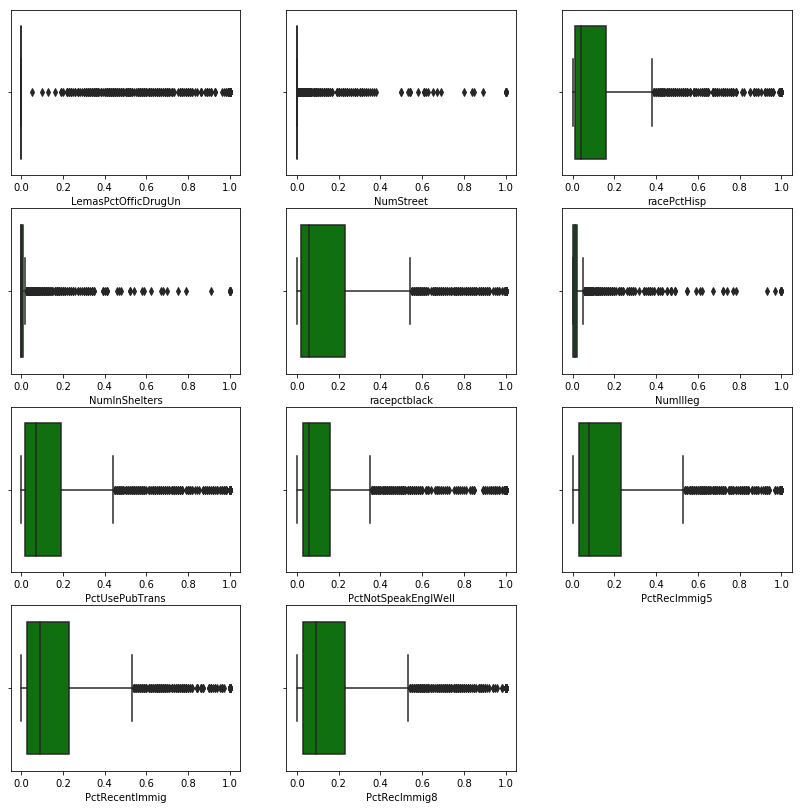

In [15]:
i = 1
plt.figure(figsize=(14,14))
for feature in features:
    plt.subplot(4,3,i)
    sns.boxplot(df[feature], color = "green")
    i+=1

### f) LinearRegression using least squares

In [16]:
lr = LinearRegression()
lr = lr.fit(train_X, train_Y)
print("Training Error: ", mean_squared_error(train_Y, lr.predict(train_X)))
print("Testing Error: ", mean_squared_error(test_Y, lr.predict(test_X)))

Training Error:  0.016269615741740996
Testing Error:  0.7897255274596975


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### g) Ridge Regression with Alpha chosen using Cross Validation (*RidgeCV performs CV on its own*)

In [17]:
ridgeCV = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), cv = 5)
ridgeCV = ridgeCV.fit(train_X, train_Y)
print("Training Error: ", mean_squared_error(train_Y, ridgeCV.predict(train_X)))
print("Testing Error: ", mean_squared_error(test_Y, ridgeCV.predict(test_X)))
print("Alpha chosen: ", ridgeCV.alpha_)

Training Error:  0.016693529119705793
Testing Error:  0.01773708110430367
Alpha chosen:  1.0


### h) Lasso Regression with Alpha chosen using Cross Validation (*LassoCV performs CV on its own*)

In [18]:
lassoCV = LassoCV(tol = 0.001, cv = 5)
lassoCV = lassoCV.fit(train_X, train_Y)
print("Training Error: ", mean_squared_error(train_Y, lassoCV.predict(train_X)))
print("Testing Error: ", mean_squared_error(test_Y, lassoCV.predict(test_X)))
print("Alpha chosen: ", lassoCV.alpha_)

Training Error:  0.017027434896421147
Testing Error:  0.017736195421703134
Alpha chosen:  0.0001245408743775853


In [19]:
features_selected = []
for i in range(len(lassoCV.coef_)):
    if lassoCV.coef_[i] == 0 or lassoCV.coef_[i] == -0:
        continue
    features_selected.append(df.columns[i]) 
print("Number of features selected : ", len(features_selected))
print("Features selected: ")
features_selected

Number of features selected :  75
Features selected: 


['racepctblack',
 'racePctAsian',
 'agePct12t21',
 'agePct12t29',
 'pctUrban',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctEmploy',
 'PctEmplManu',
 'PctOccupManu',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec10',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctHousLess3BR',
 'MedNumBR',
 'HousVacant',
 'PctHousOccup',
 'PctVacantBoarded',
 'PctVacMore6Mos',
 'MedYrHousBuilt',
 'PctHousNoPhone',
 'PctWOFullPlumb',
 'OwnOccLowQuart',
 'RentLowQ',
 'MedRent',
 'MedRentPctHousInc',
 'MedOwnCostPctInc',
 'MedOwnCostPctIncNoMtg',
 'NumInShelters',
 'NumStreet',
 'PctForeignBorn'

#### *The dataset is already normalized, hence as per professors comment on piazza, disregarding the normalizing part of this subquestion*

### i) PCR (5-Fold Cross Validation used to find best M)

In [20]:
avg_train_errors = {}
avg_testing_errors = {}
columns = ["PC1"]
for n_components in range(1, len(train_X.columns)):
    pca = PCA(n_components=n_components)
    pca_train_X = pca.fit_transform(train_X)
    cv = KFold(n_splits=5)
    training_errors = []
    testing_errors = []
    for train_index, test_index in cv.split(pca_train_X, train_Y):
        lr = LinearRegression()
        lr.fit(pca_train_X[train_index], train_Y[train_index])
        training_errors.append(mean_squared_error(train_Y[train_index], lr.predict(pca_train_X[train_index])))
        testing_errors.append(mean_squared_error(train_Y[test_index], lr.predict(pca_train_X[test_index])))
    avg_train_errors[n_components] = np.mean(training_errors)
    avg_testing_errors[n_components] = np.mean(testing_errors)

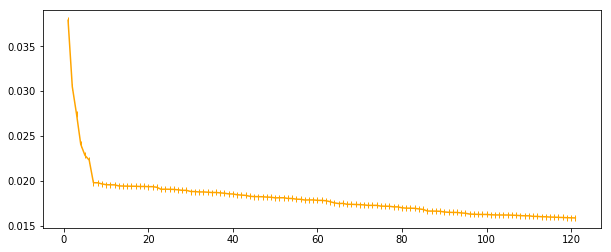

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(avg_train_errors.keys(), avg_train_errors.values(), marker = "|", color = "orange")    

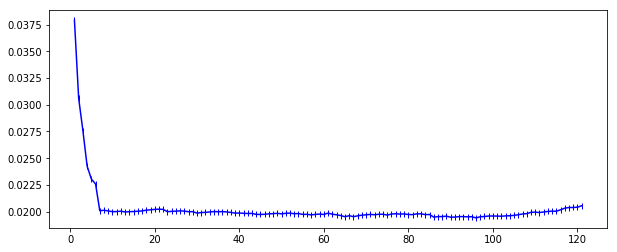

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(avg_testing_errors.keys(), avg_testing_errors.values(), marker = "|", color = "blue")    

In [23]:
sorted_avg_testing_errors = sorted(avg_testing_errors.items(), key = operator.itemgetter(1))
sorted_avg_testing_errors

[(96, 0.01941366918840024),
 (90, 0.019481089586070532),
 (86, 0.019487319770512906),
 (91, 0.01949042110780736),
 (94, 0.019513498612997813),
 (97, 0.019521619736996954),
 (65, 0.019525782584363827),
 (95, 0.01952695848166218),
 (67, 0.019530808366557056),
 (87, 0.019534011798015415),
 (92, 0.019534873136340437),
 (93, 0.019537946220913965),
 (88, 0.019538096595149927),
 (98, 0.019546841983237997),
 (102, 0.01957005444085538),
 (89, 0.01957952538956177),
 (101, 0.019585746521881154),
 (99, 0.019590809725905635),
 (100, 0.019592205126023107),
 (103, 0.019603801236784162),
 (68, 0.019608932266056017),
 (104, 0.01961568593335316),
 (66, 0.01962301408010456),
 (64, 0.019633752423837737),
 (105, 0.019652838230501533),
 (69, 0.0196699686880347),
 (75, 0.01967835303919115),
 (57, 0.019697678662968118),
 (70, 0.019702937528378737),
 (63, 0.019708546660236848),
 (72, 0.019709606254950312),
 (106, 0.01971105922871181),
 (84, 0.019721680598848955),
 (81, 0.01972337704009146),
 (80, 0.01973002937

### 96 seems to be the best M but 7 gives almost similar cross validation test results, hence we could use eaither of them depending upon coputational power availability.

- For M = 7, Error = 0.020082888518777823
- For M = 96 Error = 0.01941366918840024

#### For M = 96

In [24]:
pca = PCA(n_components=96)
pca_train_X = pca.fit_transform(train_X)
pca_test_X = pca.fit_transform(test_X)
lr = LinearRegression()
lr.fit(pca_train_X, train_Y)
print("Test Error obtained for M = 96: ", mean_squared_error(test_Y, lr.predict(pca_test_X)))

Test Error obtained for M = 96:  0.028992459508712737


#### For M=7:


In [25]:
pca = PCA(n_components=7)
pca_train_X = pca.fit_transform(train_X)
pca_test_X = pca.fit_transform(test_X)
lr = LinearRegression()
lr.fit(pca_train_X, train_Y)
print("Test Error obtained for M = 7: ", mean_squared_error(test_Y, lr.predict(pca_test_X)))

Test Error obtained for M = 7:  0.025366180097926398


### Inference : As we see above, M = 7 actually performs better on the test data.

### j) Using XGBoost with L1-Penalised Regression, alpha determined using 10 Fold CV

In [26]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 2, 10]
alphamse = {}
for alpha in alphas:
    param = {'max_depth': 2, 'silent': 1, 'objective': 'reg:linear', 'alpha':alpha}
    kfold = KFold(n_splits = 10)
    for train_index, test_index in kfold.split(train_X, train_Y):
        dtrain = xgb.DMatrix(train_X.iloc[train_index], train_Y[train_index])
        bst = xgb.train(param, dtrain, 10)
        dtest = xgb.DMatrix(train_X.iloc[test_index])
        pred = bst.predict(dtest)
        alphamse[alpha] = mean_squared_error(train_Y[test_index], pred)

In [27]:
print("List of Alpha's and their CV error : ")
alphamse

List of Alpha's and their CV error : 


{1e-05: 0.013457948300887557,
 0.0001: 0.013457944399797148,
 0.001: 0.013457904637208988,
 0.01: 0.013815059943785752,
 0.1: 0.014002608163857571,
 1: 0.013964075082087232,
 2: 0.014095728314864572,
 10: 0.016275139914035147}

In [28]:
alphamse = sorted(alphamse.items(), key = operator.itemgetter(1))
bestAlpha = alphamse[0][0]
print("Best value of alpha based on result from 10-Fold CV: ", bestAlpha)

Best value of alpha based on result from 10-Fold CV:  0.001


#### Plot : CV error vs Alpha

Text(0.5, 0, 'Alpha')

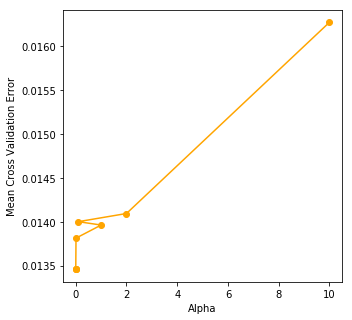

In [29]:
alphamse = dict(alphamse)
plt.figure(figsize=(5, 5))
plt.plot(alphamse.keys(), alphamse.values(), marker = "o", color = "orange")
plt.ylabel("Mean Cross Validation Error")
plt.xlabel("Alpha")

In [30]:
param = {'max_depth': 2, 'silent': 1, 'objective': 'reg:linear', 'alpha':bestAlpha}
dtrain = xgb.DMatrix(train_X, train_Y)
bst = xgb.train(param, dtrain, 10)
pred = bst.predict(dtrain)
print("Train Error obtained for alpha = : ", bestAlpha, " : ", mean_squared_error(train_Y, pred))
dtest = xgb.DMatrix(test_X)
pred = bst.predict(dtest)
print("Test Error obtained for alpha = : ", bestAlpha, " : ", mean_squared_error(test_Y, pred))

Train Error obtained for alpha = :  0.001  :  0.01754004699196329
Test Error obtained for alpha = :  0.001  :  0.017199624094132265
